<a href="https://colab.research.google.com/github/waterm80/Pedestrian_detect/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os
from os import listdir
from tqdm.notebook import tqdm
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH_train="/content/drive/MyDrive/img/labeled"
TRAIN = Path(PATH_train)

batch_size = 8
LR = 0.0001

transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [5]:
train_data = datasets.ImageFolder(TRAIN, transform=transforms)

train_size = int(0.7 * len(train_data))
valid_size = len(train_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [20]:
class CNN_Model(nn.Module):
  def __init__(self):
    super(CNN_Model, self).__init__()
    # input_shape=(3,224,224)
    self.cnn1 = nn.Conv2d(3, 16, kernel_size=5, stride=1) 
    self.relu1 = nn.ReLU(inplace=True) 
    # input_shape=(3,220,220)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    # input_shape=(16,110,110)
    self.cnn2 = nn.Conv2d(16,8, kernel_size=11, stride=1) 
    self.relu2 = nn.ReLU(inplace=True) 
    # input_shape=(8,100,100)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    # input_shape=(8,50,50)
    self.fc = nn.Linear(8 * 50 * 50, 2)     

  def forward(self, x):
    out = self.cnn1(x) 
    out = self.relu1(out)
    out = self.maxpool1(out)
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool2(out)
    out = out.view(out.size(0), -1) 
    out = self.fc(out) 
    return out

In [13]:
def train(model, n_epochs, train_loader, valid_loader, optimizer, criterion):

  train_acc_his,valid_acc_his=[],[]
  train_losses_his,valid_losses_his=[],[]

  for epoch in range(1, n_epochs+1):
      # keep track of training and validation loss
      train_loss, valid_loss = 0.0,0.0
      train_losses ,valid_losses=[],[]
      train_correct, val_correct, train_total, val_total=0,0,0,0
      train_pred, train_target=torch.zeros(8,1), torch.zeros(8,1)
      val_pred, val_target=torch.zeros(8,1), torch.zeros(8,1)
      count=0
      count2=0
      print('running epoch: {}'.format(epoch))
      ###################
      # train the model #
      ###################
      model.train()
      for data, target in tqdm(train_loader):
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          #calculate accuracy
          pred = output.data.max(dim = 1, keepdim = True)[1]
          train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
          train_total += data.size(0)
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # update training loss
          train_losses.append(loss.item()*data.size(0))
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          if count==0:
              train_pred=pred
              train_target=target.data.view_as(pred)
              count=count+1
          else:
              train_pred=torch.cat((train_pred,pred), 0)
              train_target=torch.cat((train_target,target.data.view_as(pred)), 0)
      train_pred = train_pred.cpu().view(-1).numpy().tolist()
      train_target = train_target.cpu().view(-1).numpy().tolist()
      ######################    
      # validate the model #
      ######################
      model.eval()
      for data, target in tqdm(valid_loader):
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss =criterion(output, target)
          #calculate accuracy
          pred = output.data.max(dim = 1, keepdim = True)[1]
          val_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
          val_total += data.size(0)
          valid_losses.append(loss.item()*data.size(0))
          if count2==0:
              val_pred=pred
              val_target=target.data.view_as(pred)
              count2=count+1
          else:
              val_pred=torch.cat((val_pred,pred), 0)
              val_target=torch.cat((val_target,target.data.view_as(pred)), 0)
      val_pred=val_pred.cpu().view(-1).numpy().tolist()
      val_target=val_target.cpu().view(-1).numpy().tolist()
      
      # calculate average losses
      train_loss=np.average(train_losses)
      valid_loss=np.average(valid_losses)
      
      # calculate average accuracy
      train_acc=train_correct/train_total
      valid_acc=val_correct/val_total
      train_acc_his.append(train_acc)
      valid_acc_his.append(valid_acc)
      train_losses_his.append(train_loss)
      valid_losses_his.append(valid_loss)
      # print training/validation statistics 
      print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          train_loss, valid_loss))
      print('\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
          train_acc, valid_acc))
  return train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model

In [ ]:
model1=CNN_Model()
n_epochs = 10
optimizer1 = torch.optim.Adam(model1.parameters(), lr=LR)
criterion = CrossEntropyLoss()
train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model1=train(model1,n_epochs,train_loader,valid_loader,optimizer1,criterion)

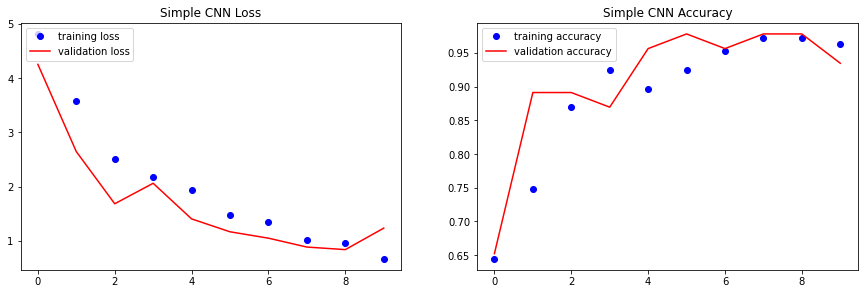

In [22]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'bo', label = 'training loss')
plt.plot(valid_losses_his, 'r', label = 'validation loss')
plt.title("Simple CNN Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his, 'bo', label = 'training accuracy')
plt.plot(valid_acc_his, 'r', label = 'validation accuracy')
plt.title("Simple CNN Accuracy")
plt.legend(loc='upper left')
plt.show()
torch.save(model1.state_dict(), "/content/drive/MyDrive/img/human_detect.pt")

In [39]:
def test(model, path):
  model.eval()
  for filename in listdir(path):
    img = Image.open("/content/drive/MyDrive/img/test/" + filename).convert('RGB')
    display(img)
    transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])     
    img = transform(img)
    img = img.unsqueeze(0)
    with torch.no_grad(): 
      output = model(img)
    if output[0][0] > output[0][1]:
      print("clear")
    else:
      print("crossing")
  return

In [ ]:
PATH_test="/content/drive/MyDrive/img/test"
TEST = Path(PATH_test)
model = CNN_Model()
model.load_state_dict(torch.load('/content/drive/MyDrive/img/human_detect.pt'))
test(model, TEST)